Student name: David Schenck<br>
Student pace: Flex<br>
Scheduled project review date/time:<br>
Instructor Name: Morgan Jones<br>
Blog post URL:

# Project Description

The World Health Organization (WHO) estimates that 2 million children below the age of 5 die from pneumonia every year, making it the leading cause of child mortality worldwide. The vast majority of cases and deaths are in developing countries, particularly in Africa and Southeast Asia.

Timely diagnosis of pneumonia is key for improving health outcomes for patients. It is also important to determine whether the pneumonia is caused by a bacterial or a viral infection since the treatment plans are very different depending on the cause.

One effective method of diagnosing pneumonia is by taking chest X-rays. A medical expert can identify the telltale signs of pneumonia by observing the X-rays, but some facilities in developing countries lack such an expert. This slows down the process of diagnosing the disease, leading to delays in medical intervention.

A potential solution is to create a computer model that can interpret the chest X-rays. Such a model could be made available to medical facilities across the world, helping to shorten the time it takes to diagnose pediatric pneumonia so that life-saving treatment can be provided faster.

In this project, I train a convolutional neural network (CNN) to diagnose pneumonia using a labeled set of chest X-rays.

### Data
The data used in this project was obtained from https://data.mendeley.com/datasets/rscbjbr9sj/3.

The data contains 5856 images of chest X-rays taken for children 5 years of age or younger. The images were examined by 2 medical experts to determine whether the patient has pneumonia and, if so, whether it is bacterial or viral pneumonia. A third expert validated their classifications.

The data is split into train and test directories, and each of those is split into "NORMAL" and "PNEUMONIA" directories. The images corresponding to a patient with bacterial pneumonia all start with "BACTERIA" and those with viral pneumonia start with "VIRUS". Patients without pneumonia all of images starting with "NORMAL".

Below is a breakdown of how many images there are in each directory:

train - NORMAL: 1349<br>
train - PNEUMONIA: 3883 (BACTERIA: 2538, VIRUS: 1345)<br>
test - NORMAL: 234<br>
test - PNEUMONIA: 390 (BACTERIA: 242, VIRUS: 148)

In addition to indicating whether the patient has pneumonia, the filename also includes a unique 6-digit code for each patient and a 4-digit code counting the number of images for that patient since some patients have multiple images. For example, a patient with multiple images will have their first image will end with 0001, second with 0002, and so on.

The images have a variety of dimensions and aspect ratios. They are cropped and resized to a standard size before they are input to the CNN.

Note: The zip file provided at https://data.mendeley.com/datasets/rscbjbr9sj/3 contains data of both chest X-ray images for diagnosing pneumonia and optimal coherence tomography (OCT) images for diagnosing eye conditions. I only use the chest X-ray images.

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Data Exploration

First, I just want to see how many images are in each directory

In [155]:
# Count the number of images in each directory
# Main directory
maindir = 'C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/'
# Subdirectories in main directory
subdirs = ['train/NORMAL/','train/PNEUMONIA/','test/NORMAL/','test/PNEUMONIA/']

for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        print(directory, '\t BACTERIA:',sum([1 if 'BACTERIA' in x else 0 for x in files]),
              'VIRUS:', sum([1 if 'VIRUS' in x else 0 for x in files]))
    else:
        print(directory, '\t \t NORMAL:', len(files))

train/NORMAL/ 	 	 NORMAL: 1349
train/PNEUMONIA/ 	 BACTERIA: 2538 VIRUS: 1345
test/NORMAL/ 	 	 NORMAL: 234
test/PNEUMONIA/ 	 BACTERIA: 242 VIRUS: 148


Some patients have multiple X-rays taken. Below I determine how many unique patients there are.

In [154]:
files_split = np.array([x.split('-') for x in files])
len(np.unique(files_split[:,1]))

202

In [158]:
for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        files_sub = [x for x in files if 'BACTERIA' in x]
        files_split = np.array([x.split('-') for x in files_sub])
        bacteria_count = len(np.unique(files_split[:,1]))
        files_sub = [x for x in files if 'VIRUS' in x]
        files_split = np.array([x.split('-') for x in files_sub])
        virus_count = len(np.unique(files_split[:,1]))
        print(directory, '\t BACTERIA:', bacteria_count, 'VIRUS:', virus_count)
        
    else:
        files_sub = [x for x in files if 'NORMAL' in x]
        files_split = np.array([x.split('-') for x in files_sub])
        normal_count = len(np.unique(files_split[:,1]))
        print(directory, '\t \t NORMAL:', normal_count)

train/NORMAL/ 	 	 NORMAL: 1008
train/PNEUMONIA/ 	 BACTERIA: 1360 VIRUS: 1090
test/NORMAL/ 	 	 NORMAL: 229
test/PNEUMONIA/ 	 BACTERIA: 77 VIRUS: 126


All of the numbers are lower than the previous numbers because we are excluding all but the first image per patient. I notice that numbers corresponding to patients with pneumonia went down more than those without pneumonia:

74.7% of images in train/NORMAL/ are considered a patient's first image.<br>
63.1% of images in train/PNEUMONIA/ are considred a patient's first image.

This indicates that patients with pneumonia tend to have more X-rays in the data than those that do not. My best guess as to why is that patients with pneumonia are beginning to show symptoms, so doctors take more X-rays to make sure they are able to identify what is wrong.

Going forward, I am only going to use the first image for each patient. The reason for this is that I want the images I use to be independent. If I use multiple images of one patient, then they will not be independent.

One thing that will make obtaining one image per patient a little harder is that some images appear to be missing for patients with viral pneumonia. The first image for each patient is supposed to end with "0001.jpeg", but some patients do not have a "0001" image.

1121 1384


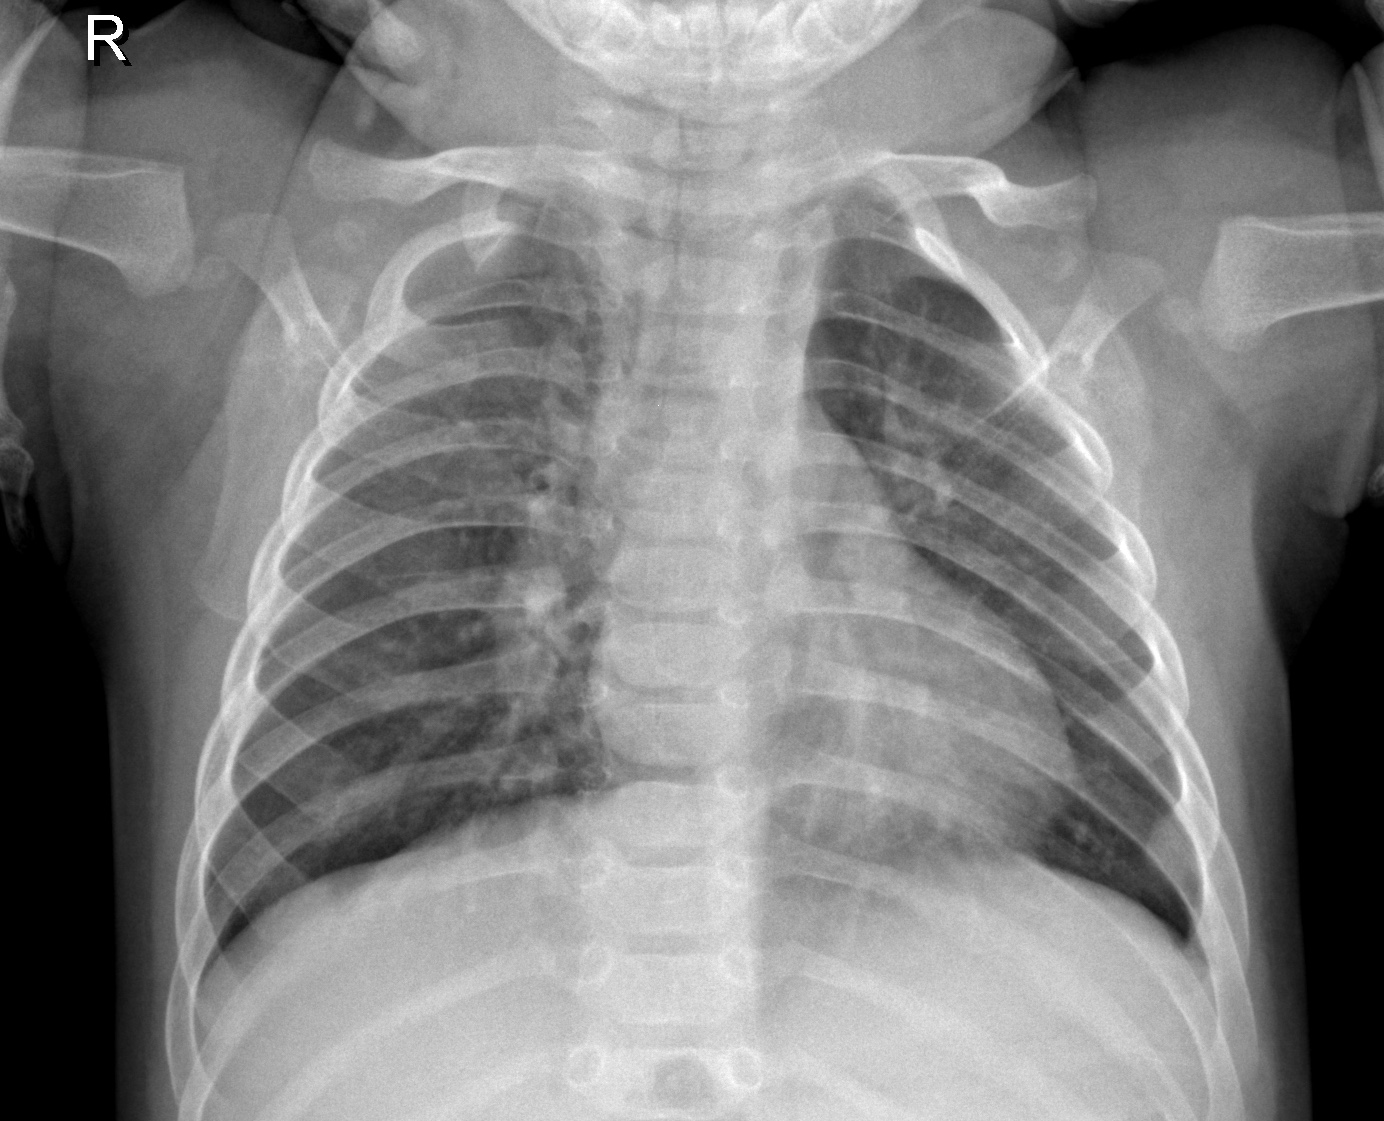

In [141]:
names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])]
img_path = names[30]
#img = load_img(img_path, target_size=(150, 150))
img = load_img(img_path)
print(img.height,img.width)
img

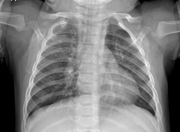

In [142]:
desired_aspect = 132/180
if img.height/img.width > desired_aspect:
    desired_height = img.width * desired_aspect
    cut = np.round((img.height - desired_height)/2,0)
    img_crop = img.crop((0,cut,img.width,img.height-cut))
else:
    desired_width = img.height / desired_aspect
    cut = np.round((img.width - desired_width)/2,0)
    img_crop = img.crop((cut,0,img.width-cut,img.height))

img_resize = img_crop.resize((180,132))
#img_crop
img_resize

In [87]:
names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])] + \
        [os.path.join(maindir+subdirs[1], name) for name in os.listdir(maindir+subdirs[1])] + \
        [os.path.join(maindir+subdirs[2], name) for name in os.listdir(maindir+subdirs[2])] + \
        [os.path.join(maindir+subdirs[3], name) for name in os.listdir(maindir+subdirs[3])]

names = [x for x in names if '0001' in x]

img_dims = []
for img_path in names:
    if 'jpeg' in img_path:
        img = load_img(img_path, color_mode='grayscale')
        img_dims.append([img.height,img.width])
img_dims = np.array(img_dims)

In [88]:
img_dims.shape

(3081, 2)

0.733283824186595


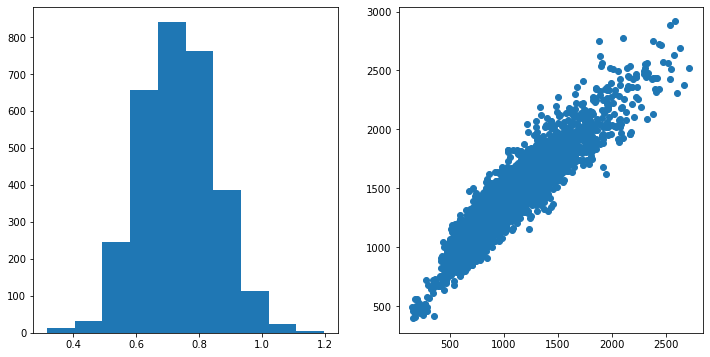

In [89]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

aspect_ratios = img_dims[:,0]/img_dims[:,1]
print(np.mean(aspect_ratios))
ax[0].hist(aspect_ratios)
ax[1].scatter(img_dims[:,0],img_dims[:,1]);

In [91]:
0.7332838*180

131.991084

(1198, 1430, 3)


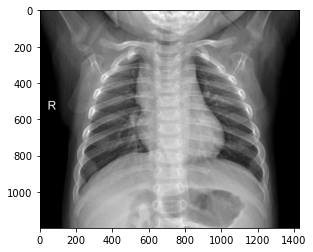

In [8]:
img_array = img_to_array(img)
print(img_array.shape)
plt.imshow(img_array[:,:,0], cmap='gray')